# BIX CHALLENGE

Solved by Petkovic Nery.

#### PREPROCESSING DATA

First, let's import the .csv files as DataFrames for preprocessing and future use in the model.

In [1]:
import pandas as pd

as_present = pd.read_csv('air_system_present_year.csv')
as_previous = pd.read_csv('air_system_previous_years.csv')

print(as_present.head())
print(as_previous.head())

  class  aa_000 ab_000 ac_000 ad_000 ae_000 af_000 ag_000 ag_001 ag_002  ...  \
0   neg      60      0     20     12      0      0      0      0      0  ...   
1   neg      82      0     68     40      0      0      0      0      0  ...   
2   neg   66002      2    212    112      0      0      0      0      0  ...   
3   neg   59816     na   1010    936      0      0      0      0      0  ...   
4   neg    1814     na    156    140      0      0      0      0      0  ...   

   ee_002  ee_003  ee_004  ee_005   ee_006  ee_007  ee_008 ee_009 ef_000  \
0    1098     138     412     654       78      88       0      0      0   
1    1068     276    1620     116       86     462       0      0      0   
2  495076  380368  440134  269556  1315022  153680     516      0      0   
3  540820  243270  483302  485332   431376  210074  281662   3232      0   
4    7646    4144   18466   49782     3176     482      76      0      0   

  eg_000  
0      0  
1      0  
2      0  
3      0  
4      

Oh, we've got a problem. We need to ensure all data is numeric in order to scikit-learn accept it. The first column clearly is a string. Let's check if the other ones need to be converted as well.

In [2]:
print(as_present.dtypes.value_counts())
print(as_previous.dtypes.value_counts())

object    170
int64       1
Name: count, dtype: int64
object    170
int64       1
Name: count, dtype: int64


Even though we see numbers from the second column on, just one of them is numeric. Also, 'na' values are strings as well. Let's convert all columns to numeric.

In [3]:
import numpy as np

# Replace class names with 0 for neg and 1 for pos.
as_present["class"] = as_present["class"].replace({"neg": "0", "pos": "1"}).astype(int)
as_previous["class"] = as_previous["class"].replace({"neg": "0", "pos": "1"}).astype(int)

# Convert 'na' strings to NumPy NaN values.
as_present.replace('na', np.nan, inplace=True)
as_previous.replace('na', np.nan, inplace=True)

# Convert the whole dataframe to float.
as_present = as_present.astype(float)
as_previous = as_previous.astype(float)

# Check the datatypes of all columns.
print(as_present.dtypes.value_counts())
print(as_previous.dtypes.value_counts())

float64    171
Name: count, dtype: int64
float64    171
Name: count, dtype: int64


Time to check missing values in the dataframe. Let's first analyze the dataframe to be used for training our model.

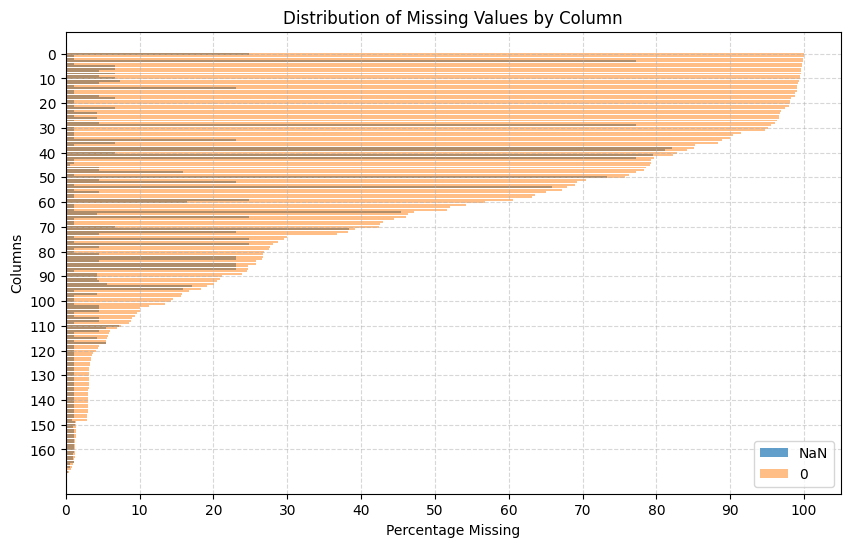

In [4]:
import matplotlib.pyplot as plt

as_previous_feat = as_previous.iloc[:, 1:]

# Get the percentage of np.nan values and of both np.nan and 0 values (combined) for each column.
percent_missing_nan = as_previous_feat.isnull().sum() * 100 / len(as_previous_feat)
percent_missing_both = (as_previous_feat.isnull() | (as_previous_feat == 0)).sum() * 100 / len(as_previous_feat)

# Creates a new dataframe with the column names and the percentages calculated above.
missing_values = pd.DataFrame({'column_name': as_previous_feat.columns, 'percent_missing_nan': percent_missing_nan, 'percent_missing_both': percent_missing_both})
missing_values.sort_values('percent_missing_both', ascending=False, inplace=True)

# Create the figure.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 0 values (foreground).
ax.barh(range(len(missing_values)), missing_values['percent_missing_nan'], label='NaN', alpha=0.7)

# Plot the NaN + 0 values (background, since they're greater than 0 values alone).
ax.barh(range(len(missing_values)), missing_values['percent_missing_both'], label='0', alpha=0.5)

# Customize the plot.
plt.xlabel('Percentage Missing')
plt.ylabel('Columns')
plt.title('Distribution of Missing Values by Column')
plt.gca().invert_yaxis()
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, len(missing_values), 10)) 

# Add a dotted grid.
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.legend()

plt.show()


Since columns have been encoded, it is hard to tell what the huge amount of zeroes or null values in some columns truly mean. Dropping some features with lots of such values would make it faster to train the model and maybe improve its performance, but some of them might be useful for the task. For that reason, let's fill the null values with the column's mean value if they are normally distributed or with its median if they aren't.

In [5]:
from scipy.stats import kstest

def null_treatment(df):
    for col in df.columns:
        _, p_value = kstest(df[col], 'norm')
        
        if p_value > 0.05:
            # Column follows a normal distribution.
            df[col] = df[col].fillna(df[col].mean())
        else:
            # Column does not follow a normal distribution.
            df[col] = df[col].fillna(df[col].median())
    
    return df

as_present_feat_n = null_treatment(as_present.iloc[:, 1:])
as_previous_feat_n = null_treatment(as_previous_feat)

170 features seems as a huge number for this model. Let's find the correlation between the columns and perform dimensionality reduction by eliminating the significant ones, thus avoiding bias introduction into linear models.

In [6]:
as_present_dr = as_present_feat_n
as_previous_dr = as_previous_feat_n

correlation_matrix = as_previous_dr.corr()

# Find pairs with correlation coefficient > 0.5.
high_correlation_pairs = []
for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.5:
            high_correlation_pairs.append((col1, col2))

for col1, col2 in high_correlation_pairs:
    if col1 in as_previous_dr.columns and col2 in as_previous_dr.columns:
        # Drop one of the columns.
        as_previous_dr.drop(col2, axis=1, inplace=True)

columns_to_drop = [col for col in as_present_dr.columns if col not in as_previous_dr.columns]
as_present_dr.drop(columns_to_drop, axis=1, inplace=True)

# Check if they have the same columns.
print(as_present_dr.columns == as_previous_dr.columns)
print(as_previous_dr.describe())

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
             aa_000        ab_000        ac_000        ad_000        ae_000  \
count  6.000000e+04  60000.000000  6.000000e+04  6.000000e+04  60000.000000   
mean   5.933650e+04      0.162500  3.362258e+08  1.434383e+05      6.535000   
std    1.454301e+05      1.687318  7.767625e+08  3.504525e+07    158.147893   
min    0.000000e+00      0.000000  0.000000e+00  0.000000e+00      0.000000   
25%    8.340000e+02      0.000000  2.000000e+01  4.200000e+01      0.000000   
50%    3.077600e+04      0.000000  1.520000e+02  1.260000e+02      0.000000   
75%    4.866800e+04      0.000000  8.480000e

While ab_000 values vary from 0 to 204, ac_000 values reach billions! Scaling our data might improve the model's performance.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold

scaler = StandardScaler()
as_previous_scaled = scaler.fit_transform(as_previous_dr)
as_present_scaled = scaler.transform(as_present_dr)

Finally, it's time to create our final training and test sets.

In [8]:
X_train = as_previous_scaled
X_test = as_present_scaled
y_train = as_previous["class"]
y_test = as_present["class"]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 66)
(16000, 66)
(60000,)
(16000,)


#### EVALUATING MODELS

We are going to evaluate the performance of three different models given our binary classification case:

1. K-Nearest Neighbors
2. Logistic Regression
3. Decision Tree

But before that, let's check for class imbalance.

In [9]:
print(y_train.value_counts())

class
0.0    59000
1.0     1000
Name: count, dtype: int64


Notice that 'pos' values represent <2% from the total. Hence, class weights shall be calculated and used in the models that have an argument for it. Let's create a boxplot comparing their accuracy.

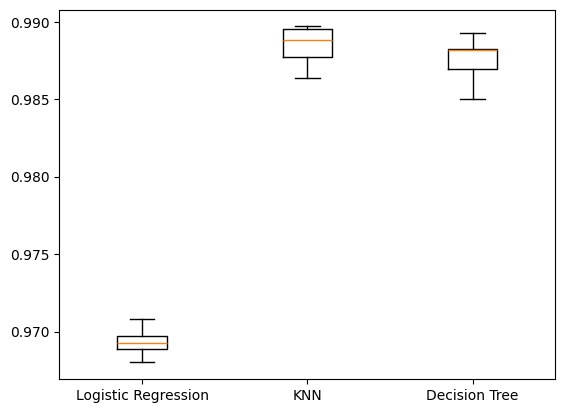

In [10]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Calcule class weights.
cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
cw_dict = {0:cw[0], 1:cw[1]}

# Instantiate models.
models = {"Logistic Regression": LogisticRegression(class_weight=cw_dict, max_iter=500, random_state=111), "KNN": KNeighborsClassifier(), "Decision Tree": DecisionTreeClassifier(class_weight=cw_dict, random_state=111)}
results = []

# Loop through the models' values.
for model in models.values():
  
  # Instantiate a KFold object.
  kf = KFold(n_splits=6, random_state=111, shuffle=True)
  
  # Perform cross-validation.
  cv_results = cross_val_score(model, X_train, y_train, cv=kf)
  results.append(cv_results)
plt.boxplot(results, tick_labels=models.keys())
plt.show()

Since the objective is to decrease the maintenance cost, avoiding corrective maintenance is paramount. Hence, *sensitivity* is the primary metric chosen to evaluate the model’s performance. That is because a single corrective maintenance service is more expensive than the inspection of 49 non-defective trucks or the preventive repair service of 19 defective ones. Therefore, getting most of true positive cases while reducing false negative ones is top priority given that sending a few non-defective trucks for maintenance is a lot cheaper than carrying out a single corrective maintenance.

In [11]:
from sklearn.metrics import recall_score, confusion_matrix

for name, model1 in models.items():
    model1.fit(X_train, y_train)
    y_pred1 = model1.predict(X_test)
    rec_score1 = recall_score(y_test, y_pred1)
    acc_score1 = model1.score(X_test, y_test)
    print(f"{name}\nSensitivity: {rec_score1}\nAccuracy: {acc_score1}\nConfusion Matrix")
    print(confusion_matrix(y_test, y_pred1))

Logistic Regression
Sensitivity: 0.9386666666666666
Accuracy: 0.9703125
Confusion Matrix
[[15173   452]
 [   23   352]]
KNN
Sensitivity: 0.4746666666666667
Accuracy: 0.985375
Confusion Matrix
[[15588    37]
 [  197   178]]
Decision Tree
Sensitivity: 0.5866666666666667
Accuracy: 0.986125
Confusion Matrix
[[15558    67]
 [  155   220]]


Lastly, let's check which features influence the model the most.

In [12]:
from sklearn.inspection import permutation_importance

#Results are scored based on recall, or sensitivity, values.
model2 = LogisticRegression(class_weight=cw_dict, max_iter=500, random_state=111).fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
rec_score2 = recall_score(y_test, y_pred2)
print(f"model2's sensitivity: {rec_score2}\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred2))
print('\n')

results = permutation_importance(model2, X_test, y_test, n_repeats=30, random_state=111, scoring='recall')

importances = dict(zip(as_previous_dr.columns, results.importances_mean))
importances = {k: v for k, v in sorted(importances.items(), key=lambda x: abs(x[1]), reverse=True)}

for feature, importance in importances.items():
    print(f'{feature}: {importance}')

model2's sensitivity: 0.9386666666666666
Confusion Matrix
[[15173   452]
 [   23   352]]


aa_000: 0.28124444444444435
ag_003: 0.011822222222222194
bs_000: 0.011377777777777749
bz_000: 0.007733333333333337
dg_000: 0.007555555555555556
bf_000: 0.007466666666666666
de_000: 0.007377777777777761
ag_001: 0.0072888888888888856
ee_008: 0.007111111111111105
bk_000: 0.005599999999999976
ay_000: 0.005333333333333301
ba_008: 0.005244444444444411
cs_006: -0.004088888888888882
db_000: 0.003999999999999963
dh_000: -0.002666666666666706
ay_001: 0.0025777777777777084
ay_009: 0.0025777777777777084
di_000: 0.0024888888888888222
av_000: -0.0024000000000000354
ce_000: 0.0023999999999999356
cx_000: -0.0020444444444444746
bc_000: 0.0019555555555554956
cj_000: 0.0019555555555554956
dy_000: -0.0017777777777778078
ag_007: 0.0016888888888888435
dl_000: 0.0009777777777777552
az_006: 0.000888888888888865
ac_000: 0.0007111111111110957
ag_000: 0.0007111111111110957
df_000: 0.0006222222222222056
ab_000: -0.000444444

Just to reassure their influence, let's compare the top 10 features with the last 10.

In [13]:
top_10_feat = list(importances.keys())[:10]
last_10_feat = list(importances.keys())[-10:]

X_train_top = scaler.fit_transform(as_previous_dr[top_10_feat])
X_test_top = scaler.transform(as_present_dr[top_10_feat])

model3 = LogisticRegression(class_weight=cw_dict, max_iter=500, random_state=111).fit(X_train_top, y_train)
model3.fit(X_train_top, y_train)
y_pred3 = model3.predict(X_test_top)
rec_score3 = recall_score(y_test, y_pred3)
acc_score3 = model3.score(X_test_top, y_test)

print(f"Top\nSensitivity: {rec_score3}\nAccuracy: {acc_score3}\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred3))

X_train_last = scaler.fit_transform(as_previous_dr[last_10_feat])
X_test_last = scaler.transform(as_present_dr[last_10_feat])

model4 = LogisticRegression(class_weight={0:1, 1:42}, max_iter=500, random_state=111).fit(X_train_last, y_train)
model4.fit(X_train_last, y_train)
y_pred4 = model4.predict(X_test_last)
rec_score4 = recall_score(y_test, y_pred4)
acc_score4 = model4.score(X_test_last, y_test)

print(f"Last\nSensitivity: {rec_score4}\nAccuracy: {acc_score4}\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred4))

Top
Sensitivity: 0.9226666666666666
Accuracy: 0.96175
Confusion Matrix
[[15042   583]
 [   29   346]]
Last
Sensitivity: 0.37066666666666664
Accuracy: 0.938375
Confusion Matrix
[[14875   750]
 [  236   139]]


model2 is ready to use!